# Example
We will use the healthcare pipeline again as example. For now, we will look at the `DataCourruption` what-if analysis.

In [1]:
import os
from jenga.corruptions.numerical import Scaling
from example_pipelines import HEALTHCARE_PY
from example_pipelines.healthcare import custom_monkeypatching
from mlwhatif import PipelineAnalyzer
from mlwhatif.analysis._data_corruption import DataCorruption

def corruption(pandas_df):
    pandas_df['num_children'] = 0
    return pandas_df

data_corruption = DataCorruption({'income':
                                  lambda pandas_df: Scaling(column='income', fraction=1.).transform(pandas_df),
                                  'num_children': corruption},
                                 corruption_percentages=[0.3, 0.6, 0.9],
                                 also_corrupt_train=True)

analysis_result = PipelineAnalyzer \
    .on_pipeline_from_py_file(HEALTHCARE_PY) \
    .add_custom_monkey_patching_module(custom_monkeypatching) \
    .add_what_if_analysis(data_corruption) \
    .execute()

report = analysis_result.analysis_to_result_reports[data_corruption]

INFO:Running instrumented original pipeline...
INFO:Importing libraries and monkey-patching them... (Imports are slow if not in sys.modules cache yet!)
INFO:---RUNTIME: Importing and monkey-patching took 3695.596933364868 ms
2022-07-26 12:03:43.144327: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-26 12:03:43.207537: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
INFO:---RUNTIME: Original pipeline execution took 1134.1898441314697 ms (excluding imports and monkey-patching)
INFO:Starting execution of 1 what-if analyses...
INFO:Start plan generation for analysis DataCorruption...
INFO:---RUNTIME: Plan generation took 7.174015045166016 ms

Let us start by looking at the report generated by the analysis.

In [2]:
report

column  corruption_percentage  metric_corrupt_test_only_L54  \
0        income                    0.3                      0.780822   
1        income                    0.6                      0.602740   
2        income                    0.9                      0.479452   
3  num_children                    0.3                      0.876712   
4  num_children                    0.6                      0.863014   
5  num_children                    0.9                      0.863014   

                        metric_corrupt_test_only_L58  \
0  <fairlearn.metrics._metric_frame.MetricFrame o...   
1  <fairlearn.metrics._metric_frame.MetricFrame o...   
2  <fairlearn.metrics._metric_frame.MetricFrame o...   
3  <fairlearn.metrics._metric_frame.MetricFrame o...   
4  <fairlearn.metrics._metric_frame.MetricFrame o...   
5  <fairlearn.metrics._metric_frame.MetricFrame o...   

   metric_corrupt_test_only_L61  metric_corrupt_train_and_test_L54  \
0                      0.261905                           0.767123   
1                      0.500000                           0.630137   
2                      0.500000                           0.904110   
3                      0.159091                           0.890411   
4                      0.144737                           0.904110   
5                      0.144737                           0.890411   

                   metric_corrupt_train_and_test_L58  \
0  <fairlearn.metrics._metric_frame.MetricFrame o...   
1  <fairlearn.metrics._metric_frame.MetricFrame o...   
2  <fairlearn.metrics._metric_frame.MetricFrame o...   
3  <fairlearn.metrics._metric_frame.MetricFrame o...   
4  <fairlearn.metrics._metric_frame.MetricFrame o...   
5  <fairlearn.metrics._metric_frame.MetricFrame o...   

   metric_corrupt_train_and_test_L61  
0                               0.40  
1                               0.50  
2                               0.25  
3                               0.25  
4                               0.25  
5                               0.25

To help us to understand what is going on, let us use some convenience functions to save the intermediate DAGs mlwhatif uses internally.

In [3]:
from mlwhatif.utils import get_project_root

INTERMEDIATE_EXTRACTION_ORIG_PATH = os.path.join(str(get_project_root()), "demo", "feature_overview",
                                                 "data_corruption-orig")
INTERMEDIATE_EXTRACTION_GENERATED_PATH = os.path.join(str(get_project_root()), "demo", "feature_overview",
                                                      "data_corruption-what-if")
INTERMEDIATE_EXTRACTION_OPTIMISED_PATH = os.path.join(str(get_project_root()), "demo", "feature_overview",
                                                      "data_corruption-what-if-optimised")

def corruption(pandas_df):
    pandas_df['num_children'] = 0
    return pandas_df

data_corruption = DataCorruption({'income':
                                  lambda pandas_df: Scaling(column='income', fraction=1.).transform(pandas_df),
                                  'num_children': corruption},
                                 corruption_percentages=[0.3, 0.6, 0.9],
                                 also_corrupt_train=True)

analysis_result = PipelineAnalyzer \
    .on_pipeline_from_py_file(HEALTHCARE_PY) \
    .add_custom_monkey_patching_module(custom_monkeypatching) \
    .add_what_if_analysis(data_corruption) \
    .save_original_dag_to_path(INTERMEDIATE_EXTRACTION_ORIG_PATH) \
    .save_what_if_dags_to_path(INTERMEDIATE_EXTRACTION_GENERATED_PATH) \
    .save_optimised_what_if_dags_to_path(INTERMEDIATE_EXTRACTION_OPTIMISED_PATH) \
    .execute()

report = analysis_result.analysis_to_result_reports[data_corruption]

INFO:Running instrumented original pipeline...
INFO:Importing libraries and monkey-patching them... (Imports are slow if not in sys.modules cache yet!)
INFO:---RUNTIME: Importing and monkey-patching took 7.776021957397461 ms
INFO:---RUNTIME: Original pipeline execution took 1087.109088897705 ms (excluding imports and monkey-patching)
INFO:Starting execution of 1 what-if analyses...
INFO:Start plan generation for analysis DataCorruption...
INFO:---RUNTIME: Plan generation took 9.779930114746094 ms
INFO:Performing Multi-Query Optimization
INFO:Estimated runtime of original DAG is 998.619794845581ms
INFO:Estimated unoptimized what-if runtime is 11983.437538146973ms
INFO:Estimated optimised what-if runtime is 7073.785305023193ms
INFO:Estimated optimisation runtime saving is 4909.652233123779ms
INFO:---RUNTIME: Multi-Query Optimization took 16.39723777770996 ms
INFO:Executing generated plan
INFO:---RUNTIME: Execution took 6863.889217376709 ms
INFO:Done!


Let us now look at the original pipeline DAG.

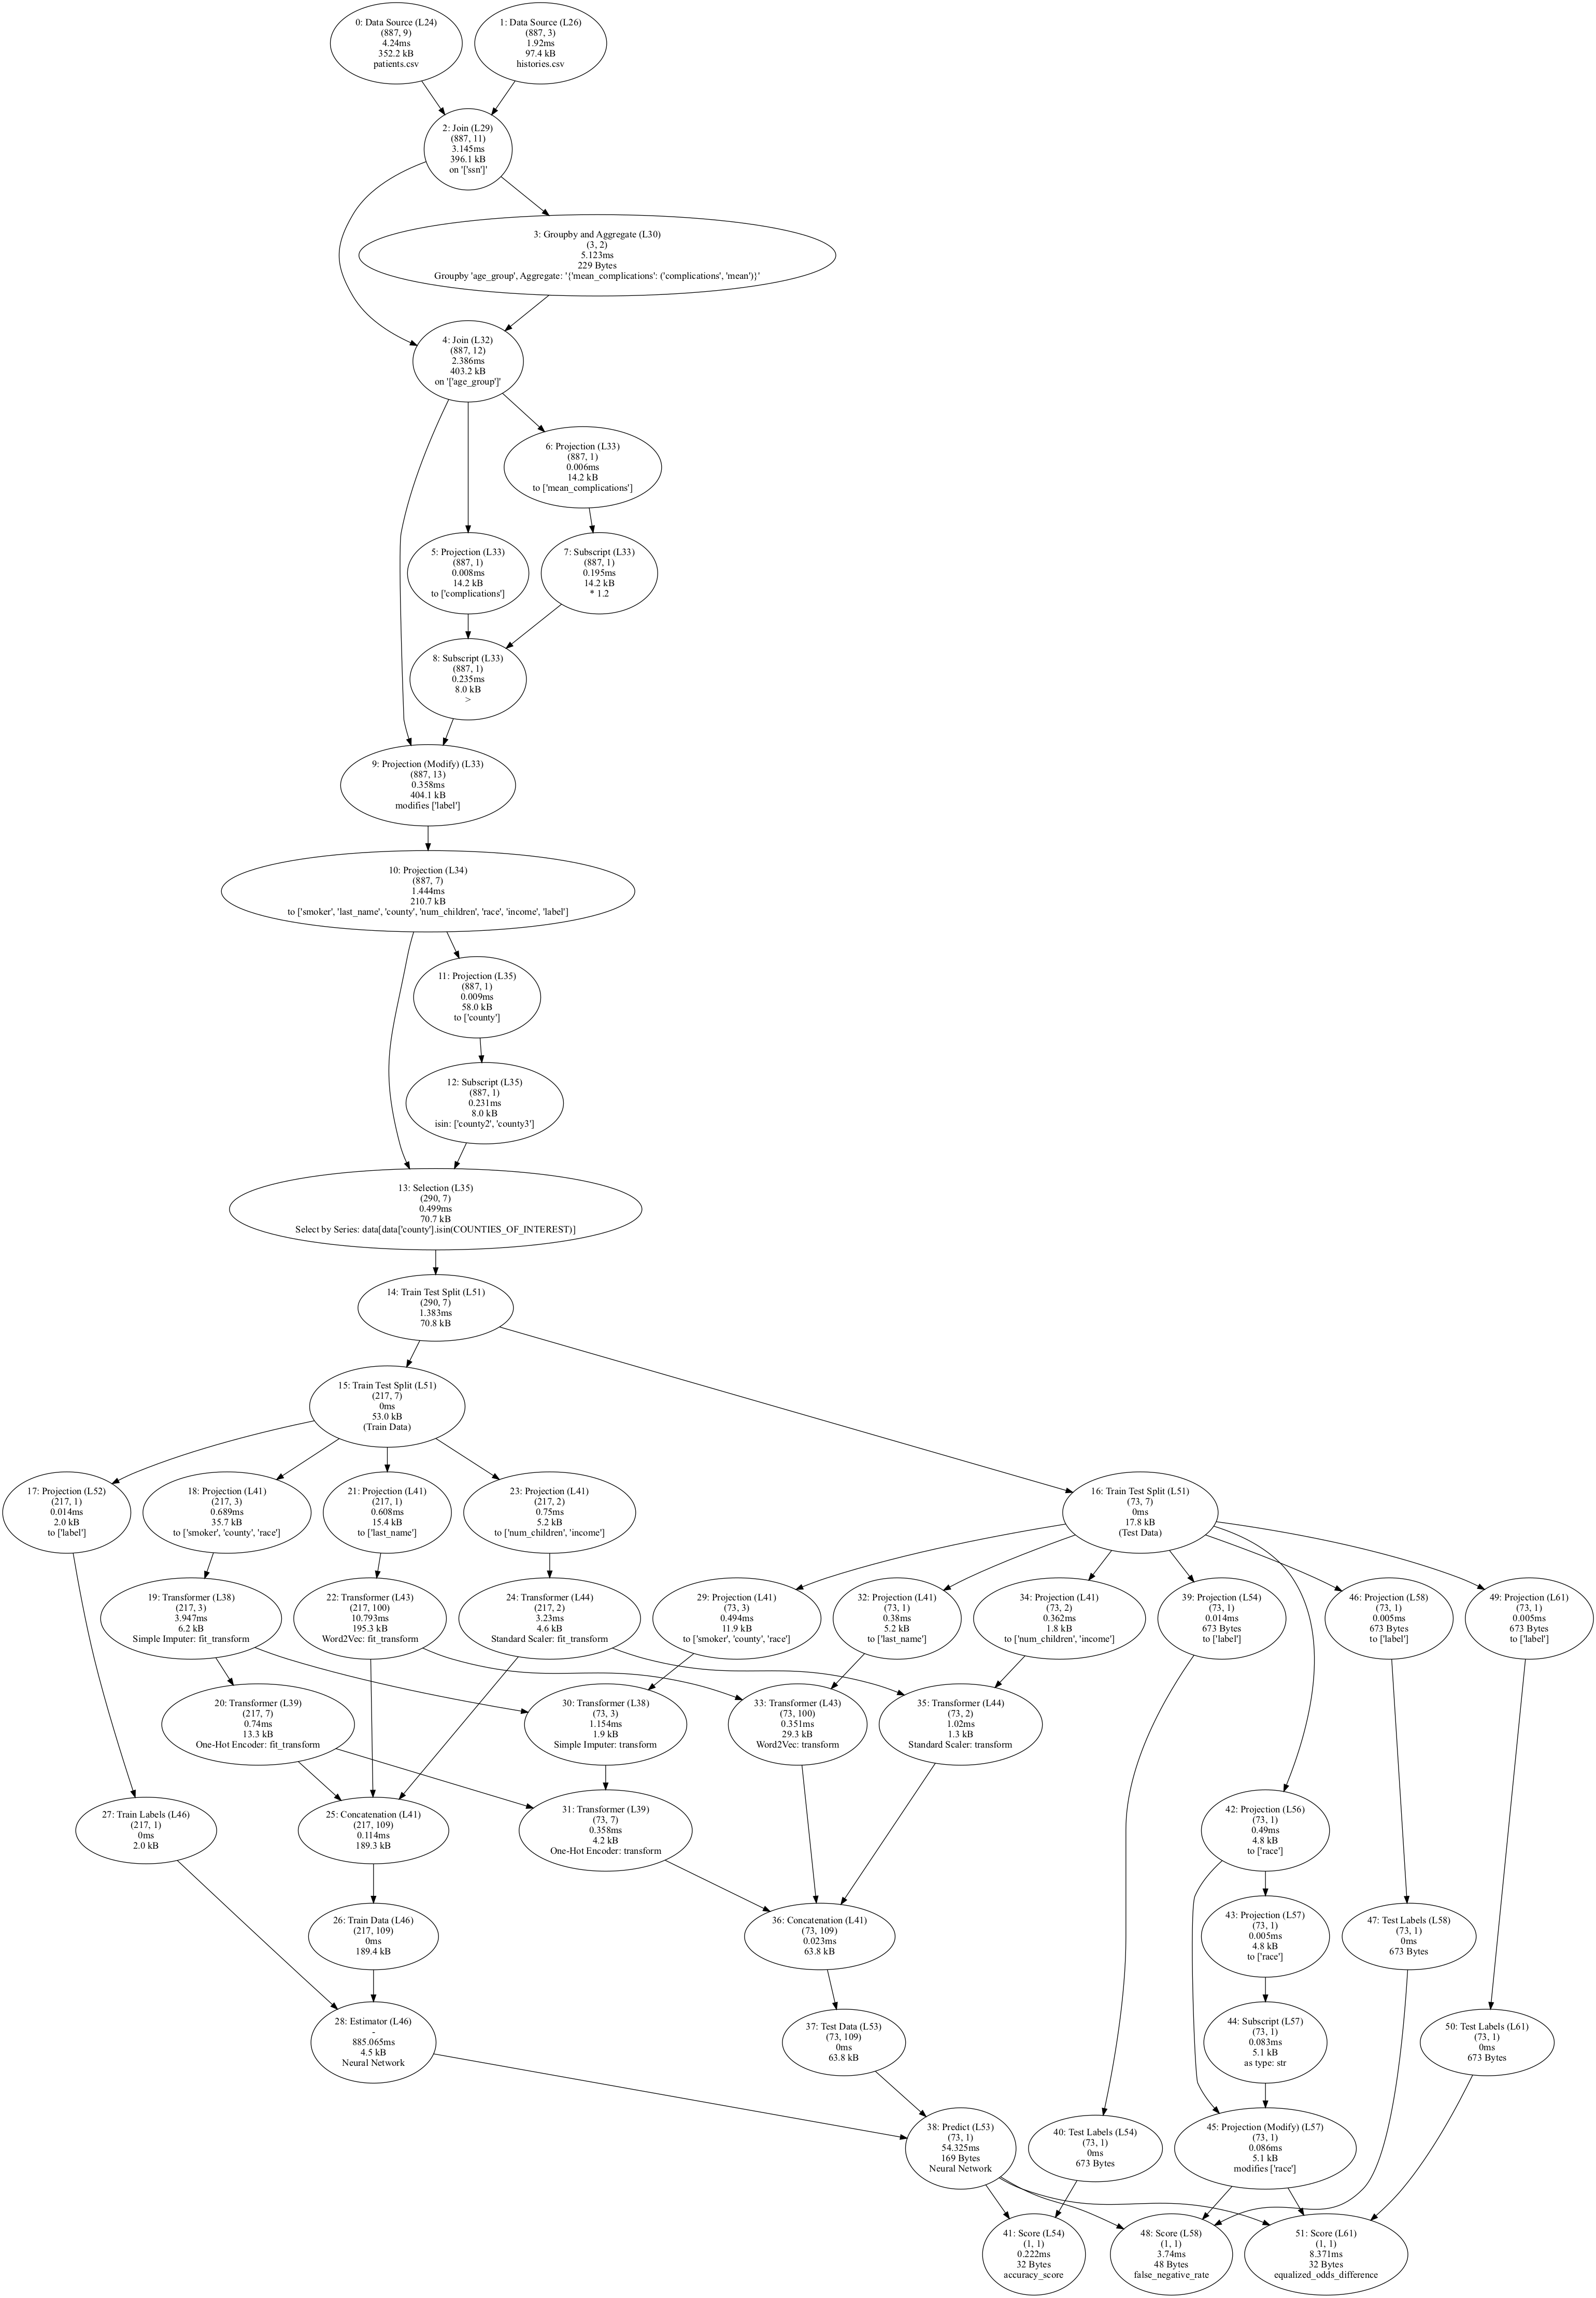

In [4]:
from IPython.display import Image
Image(filename=f"{INTERMEDIATE_EXTRACTION_ORIG_PATH}.png")

This pipeline DAG then gets rewritten to several DAGs we need for our analysis. Let us look at an example. Note the corruption operation now present in the DAG.

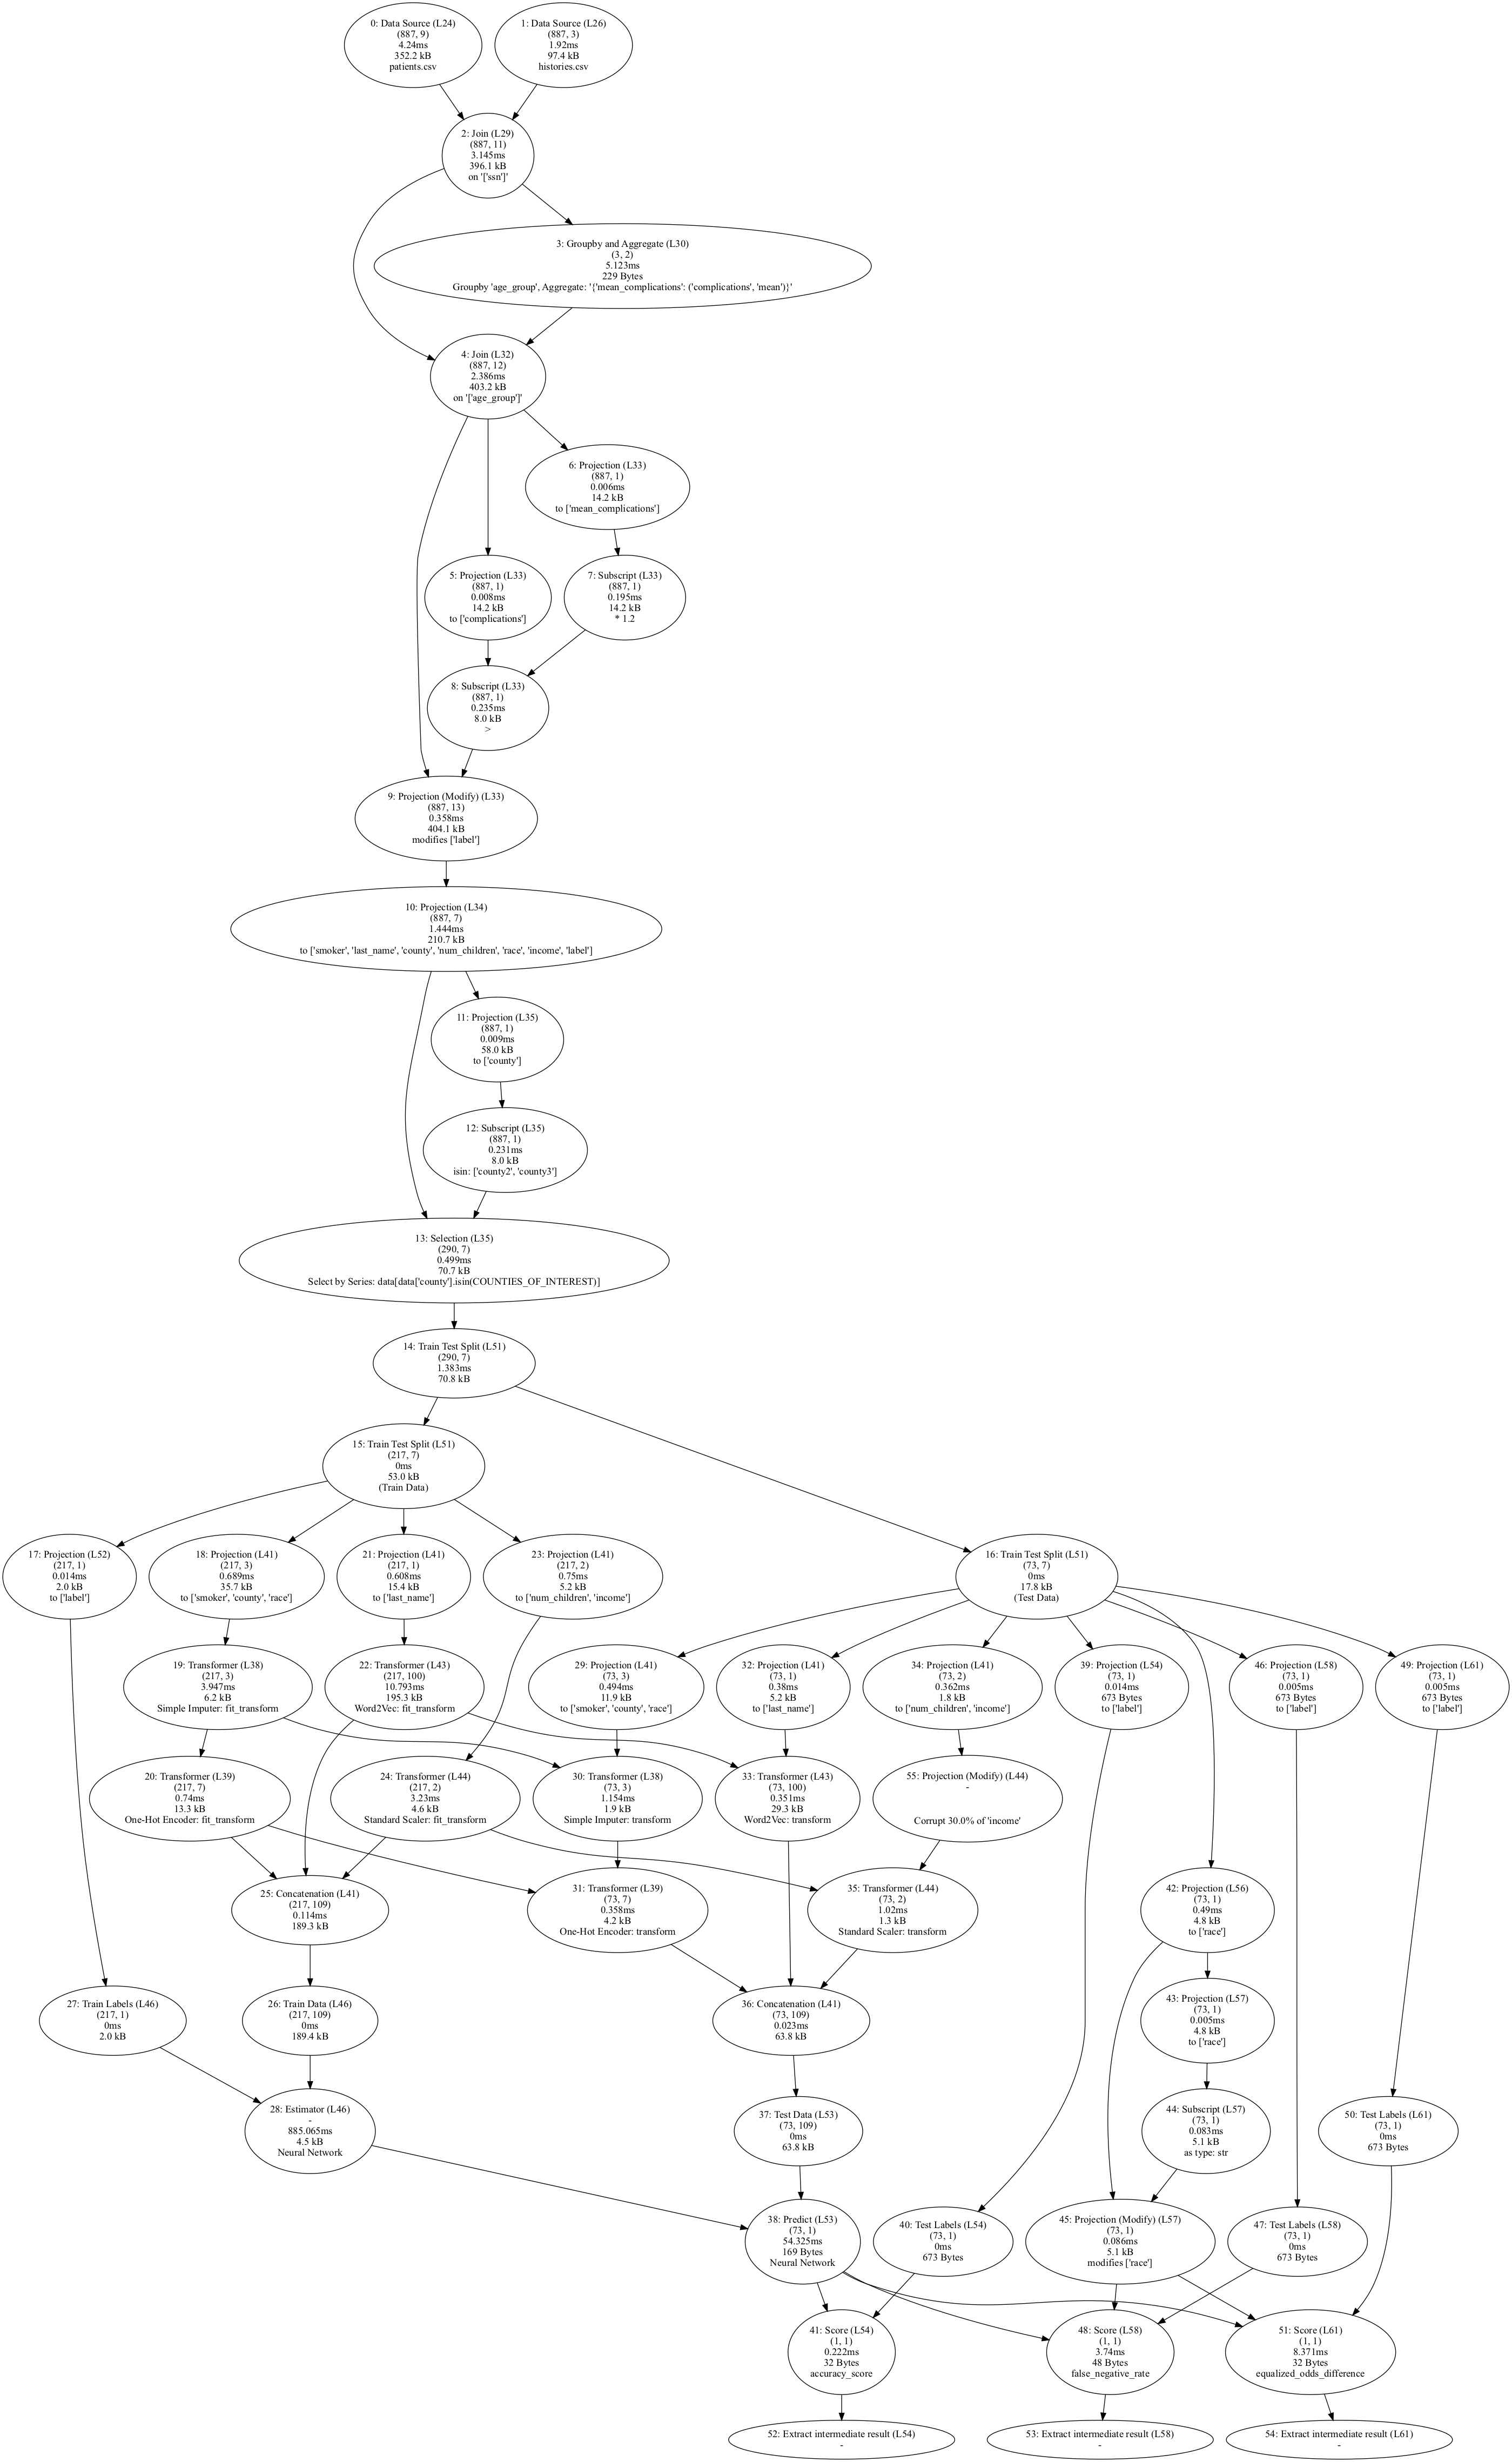

In [5]:
Image(filename=f"{INTERMEDIATE_EXTRACTION_GENERATED_PATH}-DataCorruption-0.png")

We then use a multi-query optimizer to combine all the generated DAGs for efficient execution.

In [6]:
Image(filename=f"{INTERMEDIATE_EXTRACTION_OPTIMISED_PATH}.png")

Let us take a look at how long our analysis takes without this multi-query optimizer.

In [7]:
analysis_result = PipelineAnalyzer \
    .on_pipeline_from_py_file(HEALTHCARE_PY) \
    .skip_multi_query_optimization(True) \
    .add_custom_monkey_patching_module(custom_monkeypatching) \
    .add_what_if_analysis(data_corruption) \
    .execute()

INFO:The skip_multi_query_optimization function is only intended for benchmarking!
INFO:Running instrumented original pipeline...
INFO:Importing libraries and monkey-patching them... (Imports are slow if not in sys.modules cache yet!)
INFO:---RUNTIME: Importing and monkey-patching took 11.324882507324219 ms
INFO:---RUNTIME: Original pipeline execution took 1075.5901336669922 ms (excluding imports and monkey-patching)
INFO:Starting execution of 1 what-if analyses...
INFO:Start plan generation for analysis DataCorruption...
INFO:---RUNTIME: Plan generation took 6.924152374267578 ms
INFO:Executing generated plans
INFO:---RUNTIME: Execution took 12307.912349700928 ms
INFO:Done!


Let us now look at a scenario where we only need to introduce corruptions in the test set, where we do not have model retraining that we cannot optimise away. We can compare without query optimisation...

In [8]:
test_only_data_corruption = DataCorruption({'income':
                                  lambda pandas_df: Scaling(column='income', fraction=1.).transform(pandas_df),
                                  'num_children': corruption},
                                 corruption_percentages=[0.3, 0.6, 0.9],
                                 also_corrupt_train=False)

fast_analysis_result_unopt = PipelineAnalyzer \
    .on_pipeline_from_py_file(HEALTHCARE_PY) \
    .skip_multi_query_optimization(True) \
    .add_custom_monkey_patching_module(custom_monkeypatching) \
    .add_what_if_analysis(test_only_data_corruption) \
    .execute()

INFO:The skip_multi_query_optimization function is only intended for benchmarking!
INFO:Running instrumented original pipeline...
INFO:Importing libraries and monkey-patching them... (Imports are slow if not in sys.modules cache yet!)
INFO:---RUNTIME: Importing and monkey-patching took 7.44318962097168 ms
INFO:---RUNTIME: Original pipeline execution took 1086.7116451263428 ms (excluding imports and monkey-patching)
INFO:Starting execution of 1 what-if analyses...
INFO:Start plan generation for analysis DataCorruption...
INFO:---RUNTIME: Plan generation took 6.303071975708008 ms
INFO:Executing generated plans
INFO:---RUNTIME: Execution took 6208.237886428833 ms
INFO:Done!


... and with query optimisation.

In [9]:
fast_analysis_result_opt = PipelineAnalyzer \
    .on_pipeline_from_py_file(HEALTHCARE_PY) \
    .skip_multi_query_optimization(False) \
    .add_custom_monkey_patching_module(custom_monkeypatching) \
    .add_what_if_analysis(test_only_data_corruption) \
    .execute()

INFO:The skip_multi_query_optimization function is only intended for benchmarking!
INFO:Running instrumented original pipeline...
INFO:Importing libraries and monkey-patching them... (Imports are slow if not in sys.modules cache yet!)
INFO:---RUNTIME: Importing and monkey-patching took 8.854150772094727 ms
INFO:---RUNTIME: Original pipeline execution took 1054.4776916503906 ms (excluding imports and monkey-patching)
INFO:Starting execution of 1 what-if analyses...
INFO:Start plan generation for analysis DataCorruption...
INFO:---RUNTIME: Plan generation took 4.723310470581055 ms
INFO:Performing Multi-Query Optimization
INFO:Estimated runtime of original DAG is 966.9315814971924ms
INFO:Estimated unoptimized what-if runtime is 5801.589488983154ms
INFO:Estimated optimised what-if runtime is 1373.9120960235596ms
INFO:Estimated optimisation runtime saving is 4427.677392959595ms
INFO:---RUNTIME: Multi-Query Optimization took 11.093854904174805 ms
INFO:Executing generated plan
INFO:---RUNTIME

The results from the optimised and unoptimised execution are the same, only the randomness involved in model training, which are also present when re-executing the same pipeline multiple times, might lead to minor differences.

In [10]:
fast_report_opt = fast_analysis_result_opt.analysis_to_result_reports[test_only_data_corruption]
fast_report_opt

column  corruption_percentage  metric_corrupt_test_only_L54  \
0        income                    0.3                      0.780822   
1        income                    0.6                      0.630137   
2        income                    0.9                      0.465753   
3  num_children                    0.3                      0.904110   
4  num_children                    0.6                      0.904110   
5  num_children                    0.9                      0.904110   

                        metric_corrupt_test_only_L58  \
0  <fairlearn.metrics._metric_frame.MetricFrame o...   
1  <fairlearn.metrics._metric_frame.MetricFrame o...   
2  <fairlearn.metrics._metric_frame.MetricFrame o...   
3  <fairlearn.metrics._metric_frame.MetricFrame o...   
4  <fairlearn.metrics._metric_frame.MetricFrame o...   
5  <fairlearn.metrics._metric_frame.MetricFrame o...   

   metric_corrupt_test_only_L61  
0                          0.50  
1                          0.25  
2                          0.50  
3                          0.30  
4                          0.30  
5                          0.30

In [11]:
fast_report_unopt = fast_analysis_result_unopt.analysis_to_result_reports[test_only_data_corruption]
fast_report_unopt

column  corruption_percentage  metric_corrupt_test_only_L54  \
0        income                    0.3                      0.726027   
1        income                    0.6                      0.671233   
2        income                    0.9                      0.520548   
3  num_children                    0.3                      0.876712   
4  num_children                    0.6                      0.917808   
5  num_children                    0.9                      0.876712   

                        metric_corrupt_test_only_L58  \
0  <fairlearn.metrics._metric_frame.MetricFrame o...   
1  <fairlearn.metrics._metric_frame.MetricFrame o...   
2  <fairlearn.metrics._metric_frame.MetricFrame o...   
3  <fairlearn.metrics._metric_frame.MetricFrame o...   
4  <fairlearn.metrics._metric_frame.MetricFrame o...   
5  <fairlearn.metrics._metric_frame.MetricFrame o...   

   metric_corrupt_test_only_L61  
0                      1.000000  
1                      0.333333  
2                      0.629630  
3                      0.222222  
4                      0.333333  
5                      0.250000